In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import pickle
import time

iteration = 1
sample_size = 1000000
sample_size = 100
print_per = 10

# parameters for computing morgan fingerprint
RADIUS = 2
NBITS = 2048


unlabeled_data_path = "/media/data_2t/datasets/centaur_science/all_uniq_mols_fixed.txt"

# read unlabeled data
print("reading smiles...")
tic = time.time()
with open(unlabeled_data_path, 'r') as f:
    unlabeled_smiles = f.readlines()
toc = time.time()
print("reading complete, took %.2f seconds" % (toc - tic))
num_total_unlabeled = len(unlabeled_smiles)

# sample 1 million
np.random.seed(0)
permutation = np.random.permutation(num_total_unlabeled)
sample_idx = permutation[sample_size*(iteration-1):sample_size*iteration]


feature_filepath = f"./morgan/features_iter{iteration}"
smiles_filepath = f"./sample_smiles_for_each_iteraton/smiles_iter{iteration}"
invalid_idx = []
smiles_to_write = []
with open(feature_filepath, "w") as f:
    for i in range(sample_size):
        if i % print_per == 0:
            print(i, "/", sample_size, end="\n")
        smile = unlabeled_smiles[sample_idx[i]].strip()
        mol = Chem.MolFromSmiles(smile)  # get molecule
        if mol is None:
            invalid_idx.append(i)
            continue
        with open(smiles_filepath, "a") as g:
            g.write(smile + "\n")
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, RADIUS, NBITS)
        nonzero_idx = list(fp.GetOnBits())
        for j, idx in enumerate(nonzero_idx):
            f.write("%d %d\n" % (i+1, idx+1))

idx_filepath = f"./sample_smiles_for_each_iteraton/sample_idx_iter{iteration}"
with open(idx_filepath, "bw") as f:
    pickle.dump({"sample_idx": sample_idx, "invalid_idx": invalid_idx}, f)

RDKit WARNING: [18:57:53] Enabling RDKit 2019.09.2 jupyter extensions


reading smiles...
reading complete, took 28.01 seconds
0 / 100
10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100


In [20]:
a = np.loadtxt('smiles_for_each_iteration/real_iter_policy_1_chosen_ind', dtype=int)
b = np.loadtxt('smiles_for_each_iteration/real_iter_policy_2_chosen_ind', dtype=int)
c = set(a) & set(b)
print(c)
print(len(c))

{73408, 14817, 23716, 49734, 22823, 39945, 65323, 106987, 79851, 76079, 112502, 56919, 67478, 53017, 34458, 66006, 26903, 74045}
18


In [26]:
import numpy as np
num_labeled = 13671
greedy_chosen_ind_file = 'smiles_for_each_iteration/real_iter_policy_1_chosen_ind'
greedy_chosen_scores_file = 'smiles_for_each_iteration/real_iter_scores'
ens_chosen_ind_file = 'smiles_for_each_iteration/real_iter_policy_2_chosen_ind'
smiles_file = 'smiles_for_each_iteration/smiles_sample_size_100000_iter1'
recommended_smiles_file = 'smiles_for_each_iteration/recommended_smiles_iter1'
recommended_ind_file = 'smiles_for_each_iteration/recommended_ind_iter1'

with open(smiles_file, 'r') as f:
    lines = f.readlines()

greedy_chosen_ind = np.loadtxt(greedy_chosen_ind_file, dtype=int)
greedy_chosen_scores = np.loadtxt(greedy_chosen_scores_file, dtype=float)
meaningful_ind = greedy_chosen_scores > 51.004
greedy_chosen_meaningful_ind = greedy_chosen_ind[meaningful_ind]
ens_chosen_ind = np.loadtxt(ens_chosen_ind_file, dtype=int)
ens_chosen_ind_exclude_greedy =  np.array(list(set(ens_chosen_ind) - set(greedy_chosen_meaningful_ind)))
all_chosen_ind = np.concatenate((greedy_chosen_meaningful_ind, ens_chosen_ind_exclude_greedy))
python_chosen_ind = all_chosen_ind - num_labeled - 1  # python index starts from zero
np.savetxt(recommended_ind_file, python_chosen_ind, fmt="%d")
with open(recommended_smiles_file, 'w') as f:
    for i, ind in enumerate(python_chosen_ind):
        f.write(lines[ind])


In [28]:
greedy_chosen_meaningful_ind.shape

(83,)

In [214]:
np.random.seed(0)
total_n = len(lines)
permutation = np.random.permutation(total_n)
invalid_idx = []
one_m = 1000000
for i in range(one_m):
    if i % 5000 == 0:
        print(i, end=" ")
    idx = permutation[i]
    s = lines[idx].strip()
    mol = Chem.MolFromSmiles(lines[idx].strip())
    if mol is None:
        invalid_idx.append(i)
        
print("invalid: ", len(invalid_idx))        
valid_idx = []
for i in range(one_m, total_n):
    idx = permutation[i]
    s = lines[idx].strip()
    mol = Chem.MolFromSmiles(lines[idx].strip())
    if mol is not None:
        valid_idx.append(idx)
    if len(valid_idx) == len(invalid_idx):
        break
        
permutation[invalid_idx] = valid_idx

num_samples = [100, 250, 500, 750, 1000]  # k
for i, n in enumerate(num_samples):
    num = n*1000
    sample_idx = permutation[:num]
    save_filepath = "smiles/cs_%dk_negative.smi" % n
    with open(save_filepath, "w") as f:
        f.writelines([lines[i] for i in sample_idx])

0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 110000 115000 120000 125000 130000 135000 140000 145000 150000 155000 160000 165000 170000 175000 180000 185000 

RDKit ERROR: [15:44:12] Explicit valence for atom # 19 C, 5, is greater than permitted


190000 195000 200000 205000 210000 215000 220000 225000 230000 235000 240000 245000 250000 255000 260000 265000 270000 275000 280000 285000 290000 295000 300000 305000 310000 315000 320000 325000 330000 335000 340000 345000 350000 355000 360000 365000 370000 375000 380000 385000 390000 395000 400000 405000 410000 415000 

RDKit ERROR: [15:46:51] Explicit valence for atom # 31 C, 5, is greater than permitted


420000 425000 430000 435000 440000 445000 450000 455000 460000 465000 470000 475000 480000 485000 490000 495000 500000 505000 510000 515000 

RDKit ERROR: [15:48:01] Explicit valence for atom # 17 C, 5, is greater than permitted


520000 525000 530000 535000 540000 545000 550000 555000 560000 565000 570000 575000 580000 585000 590000 595000 600000 605000 

RDKit ERROR: [15:49:03] Explicit valence for atom # 8 C, 5, is greater than permitted


610000 615000 620000 625000 630000 635000 640000 645000 650000 655000 660000 665000 670000 675000 680000 685000 690000 695000 700000 705000 710000 715000 720000 725000 730000 735000 740000 745000 750000 755000 760000 765000 770000 775000 780000 785000 790000 

RDKit ERROR: [15:51:17] Explicit valence for atom # 28 C, 5, is greater than permitted


795000 800000 805000 810000 815000 820000 825000 830000 835000 840000 845000 850000 855000 860000 865000 870000 875000 880000 

RDKit ERROR: [15:52:20] SMILES Parse Error: unclosed ring for input: 'O=Cn1c(Cl)cccO=c1c2ccc(C=NCl)cc2oc2cc(-c3ccc([N+](=O)[O-])cn3)ccc12'


885000 890000 895000 900000 905000 910000 915000 920000 925000 930000 935000 940000 945000 950000 955000 960000 965000 

RDKit ERROR: [15:53:19] Explicit valence for atom # 19 C, 5, is greater than permitted


970000 975000 980000 985000 990000 995000 invalid:  7


In [217]:
np.random.seed(0)
total_n = len(lines)
permutation = np.random.permutation(total_n)


TypeError: 'list' object is not callable

In [221]:
for s in [lines[i] for i in list(permutation[invalid_idx])]:
    print(s)

[CH3][O]/C=C/c1c(-c2ccccc2)c2ccc3c(/C=C/[CH3][O])c(-c4ccccn4)c4ccc5ccc1c1c5c4c3c21

[CH3][O]N=Cc1ccc(-c2cc(-c3ccc(-c4nncnn4)cc3)cc(-c3ccc(C=N[CH3][O])cc3)[o+]2)cc1

[CH3][O]/C=C/c1cc2ccc3ccc4cc(/C=C/[CH3][O])c5ccc1c1c2c3c4c51

[CH3][O]/C=C/c1c(C=N[CH3][O])c2ccc3ccc4c(-c5ncccn5)c(-c5ccccc5)c5ccc1c1c2c3c4c51

[CH3][O]/C=C/c1c(C2=CC=CC2)c2ccc3ccc4c(-c5ccccc5)c(C=N[CH3][O])c5ccc1c1c2c3c4c51

O=Cn1c(Cl)cccO=c1c2ccc(C=NCl)cc2oc2cc(-c3ccc([N+](=O)[O-])cn3)ccc12

[CH3][O]/C=C/c1c(-c2ccccc2)c2ccc3c(C=N[CH3][O])c(C=N[CH3][O])c4ccc5ccc1c1c5c4c3c21



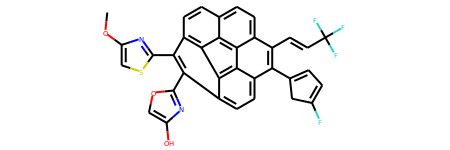

In [216]:
# Chem.MolFromSmiles('[CH3][O]/C=C/c1c(-c2ccccc2)c2ccc3c(/C=C/[CH3][O])c(-c4ccccn4)c4ccc5ccc1c1c5c4c3c21')
Chem.MolFromSmiles('COc1csc(-c2c(-c3nc(O)co3)c3ccc4c(C5=CC=C(F)C5)c(/C=C/C(F)(F)F)c5ccc6ccc2c2c6c5c4c32)n1')

In [11]:
import pickle
import numpy as np
import time

unlabeled_data_path = "/media/data_2t/datasets/centaur_science/all_uniq_mols_fixed.txt"

# read unlabeled data
print("reading smiles...")
tic = time.time()
with open(unlabeled_data_path, 'r') as f:
    unlabeled_smiles = f.readlines()
toc = time.time()
print("reading complete, took %.2f seconds" % (toc - tic))
num_total_unlabeled = len(unlabeled_smiles)



reading smiles...
reading complete, took 17.56 seconds
[ 74177180 101964239  21895535 ...  76731586  85063058  69458738]
[ 74177180 101964239  21895535 ...  76731586  85063058  69458738]


TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
np.random.seed(0)
total_n = 129640012
assert total_n == num_total_unlabeled
permutation = np.random.permutation(total_n)
with open("smiles_for_each_iteration/sample_idx_sample_size_100000_iter1", "rb") as f:
    idx = pickle.load(f)
print((idx["sample_idx"]))

In [13]:


print(permutation[:100000])
[unlabeled_smiles[i] for i in permutation[:100]]

[ 74177180 101964239  21895535 ...  76731586  85063058  69458738]


['N=Cc1c(C2=CC=C(F)C2)c2ccc3ccc4c(-c5ccc(Cl)o5)c(-c5ccc(C(F)(F)F)[nH]5)c5ccc1c1c2c3c4c51\n',
 'COc1ccc(-c2c(-c3ccc(C)cc3)c3ccc4c(/C=C/C#N)c(-c5nnc(C(F)(F)F)nn5)c5ccc6ccc2c2c6c5c4c32)nc1\n',
 'N#Cc1coc(-c2c(-c3ccc(Cl)o3)c3ccc4c(-c5ccccc5)c(-c5nnc(F)nn5)c5ccc6ccc2c2c6c5c4c32)n1\n',
 'OC1=CC=C(c2c(-c3ccc(OC(F)(F)F)o3)c3ccc4ccc5c(C#CCl)c(C6=CC=C(F)C6)c6ccc2c2c3c4c5c62)C1\n',
 'Cc1ccc(-c2c(C3=CC=C(OC(F)(F)F)S3(=O)=O)c3ccc4ccc5c(-c6nc(C)cs6)c(C6=CC=C(OC(F)(F)F)C6)c6ccc2c2c3c4c5c62)nc1\n',
 'Cc1ccc(-c2c(C3=CC=C(F)C3)c3ccc4ccc5c(-c6ccc(F)o6)c(-c6cc(S)c[nH]6)c6ccc2c2c3c4c5c62)n1C=O\n',
 'COc1coc(-c2c(/C=C/C#N)c3ccc4c(-c5ccc(O)[nH]5)c(-c5nc(C#N)co5)c5ccc6ccc2c2c6c5c4c32)n1\n',
 'N#C/C=C/c1c(C2=CC=C(C#N)S2(=O)=O)c2ccc3c(-c4ccc(F)s4)c(-c4ccc([N+](=O)[O-])[nH]4)c4ccc5ccc1c1c5c4c3c21\n',
 'Fc1ccc(-c2ccc(-c3cc(-c4ccc(-c5ccc(C(F)(F)F)cn5)cc4)[o+]c(-c4ccc(-c5ncc(S)s5)cc4)c3)cc2)s1\n',
 'O=S1(=O)C(OC(F)(F)F)=CC=C1c1c(-c2ccc(C(F)(F)F)o2)c2ccc3ccc4c(-c5ccc(Cl)s5)c(C5=CC=C(Cl)C5)c5ccc1c1c2c3c4c51\n',
 'N#C